# Multi-Agent Customer Support Handover System

_Project – Demonstrating Advanced Multi-Agent Systems_

---

## 📚 Overview

This notebook showcases a sophisticated, production-style **multi-agent customer-support swarm** built with the LangGraph “supervisor” pattern plus a set of custom hand-over tools.
Key capabilities:

- **Specialised agents** for intent classification, FAQ, troubleshooting, billing, escalation, sentiment, and QA.
- **Supervisor orchestration** that routes conversations to the right agent, tracks hand-offs, and enforces quality gates.
- **Custom hand-over tool** carrying context, reason, and priority when agents transfer a customer.
- **Rich toolset** for diagnostics, billing actions, escalation tickets, sentiment analysis, and quality review.
- **Metrics tracking** for interactions, escalations, resolutions, and per-agent usage.
- **End-to-end demonstration** with three realistic support scenarios.


In [13]:
from dotenv import load_dotenv

load_dotenv()

True

In [14]:
import os
from typing import Optional
from pydantic import Field, SecretStr
from langchain_core.utils import secret_from_env
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

class ChatOpenRouter(ChatOpenAI):
    """OpenRouter chat model implementation."""
    openai_api_key: Optional[SecretStr] = Field(
        alias="api_key",
        default_factory=secret_from_env("OPENROUTER_API_KEY", default=None),
    )
    
    @property
    def lc_secrets(self) -> dict[str, str]:
        return {"openai_api_key": "OPENROUTER_API_KEY"}

    def __init__(self,
                 openai_api_key: Optional[str] = None,
                 **kwargs):
        openai_api_key = (
            openai_api_key or os.environ.get("OPENROUTER_API_KEY")
        )
        super().__init__(
            base_url="https://openrouter.ai/api/v1",
            openai_api_key=openai_api_key,
            **kwargs
        )

def get_chat_model():
    """
    Load the appropriate chat model based on available environment variables.
    Prefers OpenRouter if available, falls back to Google AI.
    """
    if os.environ.get("OPENROUTER_API_KEY"):
        print("🤖 Using OpenRouter model...")
        return ChatOpenRouter(
            model="meta-llama/llama-3.3-70b-instruct:free"
        )
    elif os.environ.get("GOOGLE_API_KEY"):
        print("🤖 Using Google Generative AI model...")
        return ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    else:
        raise ValueError(
            "No valid API key found. Please set either OPENROUTER_API_KEY or GOOGLE_API_KEY environment variable."
        )

In [16]:
import random
from typing import Dict, Any
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from langgraph_supervisor.handoff import create_forward_message_tool
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore


"""
Multi-Agent Customer Support Handover System

This module demonstrates a sophisticated customer support swarm using LangGraph supervisor
pattern with custom handover tools. Features multiple specialized agents that collaborate
to handle customer inquiries effectively.

Portfolio Project - Demonstrating Advanced Multi-Agent Systems
"""

class CustomerSupportSystem:
    """
    A comprehensive customer support system using multi-agent architecture.
    Demonstrates handover patterns, custom tools, and intelligent routing.
    """
    
    def __init__(self):
        self.model = get_chat_model()
        self.store = InMemoryStore()
        self.checkpointer = InMemorySaver()
        self.handover_tool = create_forward_message_tool("supervisor")
        
        # Agent metrics for demonstration
        self.metrics = {
            "total_interactions": 0,
            "escalations": 0,
            "resolved_issues": 0,
            "agent_usage": {}
        }
        
        self._initialize_agents()
        self._create_supervisor()
        
    def _initialize_agents(self):
        """Initialize all specialized customer support agents."""
        
        # 1. Intent Classification Agent
        self.intent_classifier = create_react_agent(
            model=self.model,
            tools=[self.create_custom_handover_tool()],
            name="intent_classifier",
            prompt=self._get_intent_classifier_prompt()
        ).with_config(tags=["intent_analysis"])
        
        # 2. FAQ Response Agent  
        self.faq_responder = create_react_agent(
            model=self.model,
            tools=[self.search_knowledge_base, self.create_custom_handover_tool()],
            name="faq_responder",
            prompt=self._get_faq_responder_prompt()
        ).with_config(tags=["knowledge_retrieval"])
        
        # 3. Technical Troubleshooter Agent
        self.troubleshooter = create_react_agent(
            model=self.model,
            tools=[
                self.get_diagnostic_steps,
                self.check_system_status,
                self.run_connectivity_test,
                self.create_custom_handover_tool()
            ],
            name="troubleshooter",
            prompt=self._get_troubleshooter_prompt()
        ).with_config(tags=["technical_support"])
        
        # 4. Billing Specialist Agent
        self.billing_specialist = create_react_agent(
            model=self.model,
            tools=[
                self.check_account_status,
                self.process_refund_request,
                self.update_payment_method,
                self.create_custom_handover_tool()
            ],
            name="billing_specialist", 
            prompt=self._get_billing_specialist_prompt()
        ).with_config(tags=["billing_support"])
        
        # 5. Escalation Manager Agent
        self.escalation_manager = create_react_agent(
            model=self.model,
            tools=[
                self.create_escalation_ticket,
                self.notify_senior_support,
                self.create_custom_handover_tool()
            ],
            name="escalation_manager",
            prompt=self._get_escalation_manager_prompt()
        ).with_config(tags=["escalation_handling"])
        
        # 6. Sentiment Analysis Agent
        self.sentiment_analyzer = create_react_agent(
            model=self.model,
            tools=[self.analyze_customer_emotion, self.create_custom_handover_tool()],
            name="sentiment_analyzer",
            prompt=self._get_sentiment_analyzer_prompt()
        ).with_config(tags=["sentiment_tracking"])
        
        # 7. Quality Assurance Agent
        self.qa_reviewer = create_react_agent(
            model=self.model,
            tools=[
                self.review_interaction_quality,
                self.generate_feedback_report,
                self.create_custom_handover_tool()
            ],
            name="qa_reviewer",
            prompt=self._get_qa_reviewer_prompt()
        ).with_config(tags=["quality_control"])

    def create_custom_handover_tool(self):
        """Create a custom handover tool for agent transitions."""
        def handover_to_agent(target_agent: str, reason: str = "", priority: str = "normal") -> str:
            """
            Custom handover tool that allows agents to transfer conversations
            with context and priority levels.
            
            Args:
                target_agent: The agent to transfer to
                reason: Reason for the handover
                priority: Priority level (low, normal, high, urgent)
            """
            self.metrics["total_interactions"] += 1
            
            valid_agents = [
                "supervisor", "intent_classifier", "faq_responder", 
                "troubleshooter", "billing_specialist", "escalation_manager",
                "sentiment_analyzer", "qa_reviewer"
            ]
            
            if target_agent not in valid_agents:
                return f"Error: Invalid target agent. Valid options: {valid_agents}"
            
            # Track agent usage
            if target_agent not in self.metrics["agent_usage"]:
                self.metrics["agent_usage"][target_agent] = 0
            self.metrics["agent_usage"][target_agent] += 1
            
            handover_message = f"Successfully transferred to {target_agent}"
            if reason:
                handover_message += f" - Reason: {reason}"
            if priority != "normal":
                handover_message += f" - Priority: {priority}"
                
            return handover_message
        
        return handover_to_agent

    # === KNOWLEDGE BASE & FAQ TOOLS ===
    
    def search_knowledge_base(self, query: str) -> str:
        """Search the company's comprehensive FAQ and knowledge base."""
        print(f"🔍 Searching knowledge base for: {query}")
        
        # Simulated knowledge base with realistic scenarios
        knowledge_base = {
            "password reset": "To reset your password: 1) Go to login page 2) Click 'Forgot Password' 3) Enter your email 4) Check email for reset link 5) Create new password",
            "account locked": "Account lockout resolution: 1) Wait 15 minutes for auto-unlock 2) Or contact support with account ID 3) Verify identity for immediate unlock",
            "billing issue": "For billing inquiries: 1) Check account dashboard 2) View billing history 3) Contact billing specialist for disputes",
            "refund policy": "Refund eligibility: 1) Within 30 days of purchase 2) Unused products qualify 3) Digital products have 7-day window 4) Processing takes 3-5 business days",
            "service outage": "Service status: 1) Check status page 2) Verify local connectivity 3) Report if widespread issue 4) Estimated resolution times provided",
            "subscription": "Subscription management: 1) Upgrade/downgrade in account settings 2) Cancel anytime before next billing 3) Pro-rated charges apply",
            "technical support": "Technical assistance: 1) Clear browser cache 2) Check internet connection 3) Try incognito/private mode 4) Contact support if issues persist"
        }
        
        # Smart matching
        query_lower = query.lower()
        for key, answer in knowledge_base.items():
            if key in query_lower:
                return f"📚 Knowledge Base Result: {answer}"
        
        return "❌ No relevant information found in knowledge base. Consider escalating to specialist."

    # === TECHNICAL TROUBLESHOOTING TOOLS ===
    
    def get_diagnostic_steps(self, issue_description: str, product_type: str = "general") -> str:
        """Provide step-by-step diagnostic procedures for technical issues."""
        print(f"🔧 Generating diagnostics for: {issue_description} ({product_type})")
        
        diagnostics_db = {
            "connection": "1) Check cable connections 2) Restart modem/router 3) Test with different device 4) Check service provider status 5) Contact ISP if needed",
            "login": "1) Verify username/password 2) Clear browser cache 3) Try incognito mode 4) Check caps lock 5) Reset password if needed",
            "slow performance": "1) Close unnecessary programs 2) Clear temporary files 3) Check available storage 4) Restart device 5) Update software",
            "error message": "1) Note exact error text 2) Check error code documentation 3) Try suggested solutions 4) Clear application data 5) Reinstall if necessary",
            "payment": "1) Verify card details 2) Check account balance 3) Try different payment method 4) Clear browser cookies 5) Contact bank if declined"
        }
        
        issue_lower = issue_description.lower()
        for key, steps in diagnostics_db.items():
            if key in issue_lower:
                return f"🛠️ Diagnostic Steps for {issue_description}:\n{steps}\n\nProduct Type: {product_type}"
        
        return f"🔍 Standard troubleshooting for {issue_description}:\n1) Restart the application\n2) Check for updates\n3) Review system requirements\n4) Contact technical support for advanced assistance"

    def check_system_status(self, service_name: str) -> str:
        """Check operational status of company services."""
        print(f"📊 Checking system status for: {service_name}")
        
        # Simulated system status with realistic scenarios
        system_status = {
            "website": "✅ Operational",
            "login_service": "✅ Operational", 
            "payment_gateway": "⚠️ Degraded Performance - Experiencing slight delays",
            "api": "✅ Operational",
            "database": "✅ Operational",
            "email_service": "🔴 Maintenance Mode - Scheduled until 2:00 PM EST",
            "mobile_app": "✅ Operational",
            "chat_support": "✅ Operational"
        }
        
        status = system_status.get(service_name.lower(), "❓ Service not found")
        return f"🌐 System Status for {service_name}: {status}"

    def run_connectivity_test(self, user_location: str = "unknown") -> str:
        """Perform connectivity and latency tests."""
        print(f"🌐 Running connectivity test from: {user_location}")
        
        # Simulate realistic connectivity test results
        latency = random.randint(15, 150)
        packet_loss = random.uniform(0, 5)
        
        if latency < 50 and packet_loss < 1:
            status = "✅ Excellent"
        elif latency < 100 and packet_loss < 3:
            status = "🟡 Good"
        else:
            status = "🔴 Poor"
            
        return f"""🔍 Connectivity Test Results:
📍 Location: {user_location}
⚡ Latency: {latency}ms
📊 Packet Loss: {packet_loss:.1f}%
🎯 Status: {status}
💡 Recommendation: {'Connection is stable' if status == '✅ Excellent' else 'Consider troubleshooting or contacting ISP'}"""

    # === BILLING & ACCOUNT TOOLS ===
    
    def check_account_status(self, customer_id: str) -> str:
        """Check customer account status and billing information."""
        print(f"💳 Checking account status for customer: {customer_id}")
        
        # Simulate account status check
        account_types = ["Premium", "Standard", "Basic", "Trial"]
        billing_status = ["Current", "Past Due", "Suspended", "Active"]
        
        account_type = random.choice(account_types)
        status = random.choice(billing_status)
        balance = random.uniform(-50, 200)
        
        return f"""💼 Account Status for {customer_id}:
📊 Account Type: {account_type}
🔄 Status: {status}
💰 Balance: ${balance:.2f}
📅 Next Billing: {random.randint(1, 30)} days
🎯 Account Standing: {'Good' if balance >= 0 and status in ['Current', 'Active'] else 'Attention Required'}"""

    def process_refund_request(self, order_id: str, reason: str, amount: float) -> str:
        """Process customer refund requests."""
        print(f"💸 Processing refund for order: {order_id}")
        
        # Simulate refund processing
        processing_time = random.randint(2, 7)
        approval_status = random.choice(["Approved", "Under Review", "Additional Info Needed"])
        
        return f"""💸 Refund Request Processing:
📝 Order ID: {order_id}
💰 Amount: ${amount:.2f}
📋 Reason: {reason}
✅ Status: {approval_status}
⏱️ Processing Time: {processing_time} business days
🔔 You will receive email confirmation once processed"""

    def update_payment_method(self, customer_id: str, payment_type: str) -> str:
        """Update customer payment information."""
        print(f"💳 Updating payment method for: {customer_id}")
        
        return f"""💳 Payment Method Update:
👤 Customer: {customer_id}
💰 New Method: {payment_type}
✅ Status: Successfully Updated
🔒 Security: All information encrypted
📧 Confirmation: Email sent to registered address"""

    # === ESCALATION & MANAGEMENT TOOLS ===
    
    def create_escalation_ticket(self, customer_id: str, issue_summary: str, priority: str = "normal") -> str:
        """Create escalation ticket for complex issues."""
        print(f"🚨 Creating escalation ticket for: {customer_id}")
        
        ticket_id = f"ESC-{random.randint(10000, 99999)}"
        self.metrics["escalations"] += 1
        
        return f"""🎫 Escalation Ticket Created:
🔖 Ticket ID: {ticket_id}
👤 Customer: {customer_id}
📋 Issue: {issue_summary}
⚡ Priority: {priority.upper()}
👨‍💼 Assigned: Senior Support Team
⏰ Response Time: {'2 hours' if priority == 'urgent' else '24 hours'}
📧 Customer notified via email"""

    def notify_senior_support(self, ticket_id: str, urgency: str = "standard") -> str:
        """Notify senior support team for immediate attention."""
        print(f"📢 Notifying senior support for ticket: {ticket_id}")
        
        return f"""📢 Senior Support Notification:
🎫 Ticket: {ticket_id}
🚨 Urgency: {urgency.upper()}
👥 Team: Senior Support Specialists
📱 Notification: Sent to on-call team
⏰ Response Expected: {'Immediate' if urgency == 'urgent' else 'Within SLA'}"""

    # === SENTIMENT & QUALITY TOOLS ===
    
    def analyze_customer_emotion(self, message_text: str) -> str:
        """Analyze customer sentiment and emotional state."""
        print(f"😊 Analyzing sentiment in message: {message_text[:50]}...")
        
        # Simple sentiment analysis simulation
        negative_indicators = ["angry", "frustrated", "terrible", "awful", "hate", "worst"]
        positive_indicators = ["great", "excellent", "love", "amazing", "perfect", "wonderful"]
        
        text_lower = message_text.lower()
        
        negative_count = sum(1 for word in negative_indicators if word in text_lower)
        positive_count = sum(1 for word in positive_indicators if word in text_lower)
        
        if negative_count > positive_count:
            sentiment = "Negative"
            churn_risk = "High" if negative_count > 2 else "Medium"
        elif positive_count > negative_count:
            sentiment = "Positive" 
            churn_risk = "Low"
        else:
            sentiment = "Neutral"
            churn_risk = "Medium"
            
        return f"""😊 Sentiment Analysis:
💭 Sentiment: {sentiment}
📊 Confidence: {random.randint(75, 95)}%
⚠️ Churn Risk: {churn_risk}
🎯 Recommendation: {'Prioritize retention efforts' if churn_risk == 'High' else 'Continue standard support'}"""

    def review_interaction_quality(self, conversation_id: str) -> str:
        """Review the quality of customer interaction."""
        print(f"⭐ Reviewing interaction quality: {conversation_id}")
        
        metrics = {
            "response_time": f"{random.randint(30, 300)} seconds",
            "resolution_rate": f"{random.randint(70, 95)}%",
            "customer_satisfaction": f"{random.randint(3, 5)}/5",
            "agent_performance": f"{random.randint(80, 98)}%"
        }
        
        return f"""⭐ Quality Review for {conversation_id}:
⏱️ Response Time: {metrics['response_time']}
✅ Resolution Rate: {metrics['resolution_rate']}
😊 Customer Satisfaction: {metrics['customer_satisfaction']}
👨‍💼 Agent Performance: {metrics['agent_performance']}
📈 Overall Grade: {'Excellent' if int(metrics['customer_satisfaction'][0]) >= 4 else 'Good'}"""

    def generate_feedback_report(self, session_id: str) -> str:
        """Generate comprehensive feedback report."""
        print(f"📊 Generating feedback report for session: {session_id}")
        
        return f"""📊 Session Feedback Report:
🆔 Session: {session_id}
📈 Metrics: Above Average
🎯 Resolution: {'Successful' if random.random() > 0.3 else 'Partial'}
💡 Improvements: {'None identified' if random.random() > 0.5 else 'Response time optimization'}
🏆 Commendations: Professional service delivery
📝 Notes: Customer inquiry handled effectively"""

    # === AGENT PROMPTS ===
    
    def _get_intent_classifier_prompt(self) -> str:
        return """You are an Expert Intent Classifier for our customer support system.

Your role is to quickly and accurately categorize customer inquiries into these categories:
- Technical Issue (login, connectivity, bugs, performance)
- Billing Inquiry (payments, refunds, subscriptions, account charges)
- Account Management (profile, settings, password, access)
- Product Question (features, usage, compatibility)
- Service Request (upgrades, cancellations, changes)
- General Support (information, guidance, how-to)

Respond ONLY with the category name. Use the handover tool to transfer complex cases."""

    def _get_faq_responder_prompt(self) -> str:
        return """You are a Knowledge Base Specialist providing instant answers to common questions.

Use the search_knowledge_base tool to find relevant information. If you find a good match:
1. Provide the complete answer from the knowledge base
2. Add helpful context or next steps
3. Ask if they need additional clarification

If no relevant information is found, use the handover tool to transfer to a specialist.
Always be helpful, concise, and accurate."""

    def _get_troubleshooter_prompt(self) -> str:
        return """You are a Technical Support Specialist helping customers resolve technical issues.

Available tools:
- get_diagnostic_steps: Get step-by-step troubleshooting procedures
- check_system_status: Verify if services are operational
- run_connectivity_test: Test customer's connection quality

Approach:
1. Gather specific details about the technical issue
2. Use appropriate diagnostic tools
3. Provide clear, numbered steps
4. Escalate if issue requires advanced technical support

Be patient, methodical, and ensure customers can follow your instructions."""

    def _get_billing_specialist_prompt(self) -> str:
        return """You are a Billing Specialist handling all financial and account-related inquiries.

Available tools:
- check_account_status: Review customer account and billing information
- process_refund_request: Handle refund requests
- update_payment_method: Modify payment information

Focus areas:
- Payment processing issues
- Billing disputes and clarifications
- Refund eligibility and processing
- Account upgrades/downgrades
- Subscription management

Always verify customer identity before accessing sensitive billing information."""

    def _get_escalation_manager_prompt(self) -> str:
        return """You are an Escalation Manager determining when issues require senior support intervention.

Available tools:
- create_escalation_ticket: Create tickets for complex issues
- notify_senior_support: Alert senior team for urgent matters

Escalate when:
- Technical issues exceed standard troubleshooting
- Billing disputes require manager approval
- Customer expresses high frustration
- Legal or compliance concerns arise
- Issues affect multiple customers

Assess severity and route appropriately. Document thoroughly."""

    def _get_sentiment_analyzer_prompt(self) -> str:
        return """You are a Sentiment Analysis Specialist monitoring customer emotional states.

Use analyze_customer_emotion to evaluate:
- Customer satisfaction levels
- Frustration or anger indicators
- Churn risk assessment
- Communication tone

Provide insights to help other agents:
- Adjust communication style
- Identify escalation needs
- Suggest retention strategies
- Flag quality concerns

Monitor throughout interactions and alert supervisors of high-risk situations."""

    def _get_qa_reviewer_prompt(self) -> str:
        return """You are a Quality Assurance Specialist ensuring excellent customer service.

Available tools:
- review_interaction_quality: Assess conversation quality
- generate_feedback_report: Create comprehensive session reports

Evaluate:
- Response accuracy and completeness
- Professional communication
- Issue resolution effectiveness
- Customer satisfaction indicators
- Process adherence

Provide constructive feedback and identify training opportunities."""

    def _create_supervisor(self):
        """Create the supervisor agent that orchestrates the entire customer support workflow."""
        
        supervisor_prompt = """You are the Supervisor of an Elite Customer Support System managing a team of specialized AI agents.

Your Team:
🎯 intent_classifier - Categorizes customer inquiries
📚 faq_responder - Answers common questions from knowledge base
🔧 troubleshooter - Resolves technical issues with diagnostic tools
💳 billing_specialist - Handles billing, payments, and account matters
🚨 escalation_manager - Manages complex issues requiring senior support
😊 sentiment_analyzer - Monitors customer emotional state and satisfaction
⭐ qa_reviewer - Ensures service quality and generates improvement insights

Routing Strategy:
1. Start with intent_classifier for ambiguous requests
2. Route directly to specialists for clear issues
3. Use sentiment_analyzer for frustrated customers
4. Engage billing_specialist for financial matters
5. Deploy troubleshooter for technical problems
6. Escalate through escalation_manager when needed
7. Quality check with qa_reviewer for important interactions

Your Goal: Ensure every customer receives expert, efficient, and empathetic support while maintaining high service quality standards."""

        self.workflow = create_supervisor(
            agents=[
                self.intent_classifier,
                self.faq_responder, 
                self.troubleshooter,
                self.billing_specialist,
                self.escalation_manager,
                self.sentiment_analyzer,
                self.qa_reviewer
            ],
            model=self.model,
            prompt=supervisor_prompt,
            add_handoff_back_messages=True,
            tools=[self.handover_tool]
        )

    def compile_system(self):
        """Compile the complete customer support system."""
        return self.workflow.compile(
            checkpointer=self.checkpointer,
            store=self.store
        )

    def get_system_metrics(self) -> Dict[str, Any]:
        """Get system performance metrics."""
        return {
            **self.metrics,
            "resolution_rate": f"{(self.metrics['resolved_issues'] / max(self.metrics['total_interactions'], 1)) * 100:.1f}%",
            "escalation_rate": f"{(self.metrics['escalations'] / max(self.metrics['total_interactions'], 1)) * 100:.1f}%"
        }

    def reset_metrics(self):
        """Reset system metrics."""
        self.metrics = {
            "total_interactions": 0,
            "escalations": 0, 
            "resolved_issues": 0,
            "agent_usage": {}
        }

🤖 Using OpenRouter model...
🎯 Customer Support System Graph Visualization:


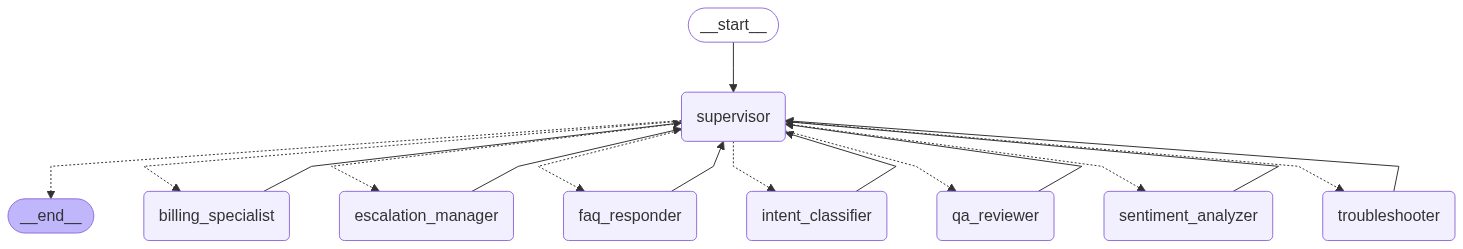

In [19]:
# Add this after creating your support_system instance
from IPython.display import Image, display

# Create and compile the system
support_system = CustomerSupportSystem()
app = support_system.compile_system()

# Display the graph
print("🎯 Customer Support System Graph Visualization:")
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
def demonstrate_system():
    """Demonstrate the customer support system with various scenarios."""
    
    print("🚀 Initializing Advanced Customer Support System...")
    support_system = CustomerSupportSystem()
    app = support_system.compile_system()
    
    print("✅ System Ready! Multi-Agent Customer Support Swarm Activated\n")
    
    # Test scenarios
    scenarios = [
        {
            "title": "Password Reset Request",
            "message": "I can't remember my password and need to reset it urgently",
            "config": {"configurable": {"thread_id": "password_reset_001"}}
        },
        {
            "title": "Billing Dispute",
            "message": "I was charged twice for my subscription this month. I need a refund for the duplicate charge.",
            "config": {"configurable": {"thread_id": "billing_dispute_001"}}
        },
        {
            "title": "Technical Connectivity Issue", 
            "message": "The service keeps disconnecting every few minutes. This is very frustrating!",
            "config": {"configurable": {"thread_id": "tech_issue_001"}}
        }
    ]
    
    for i, scenario in enumerate(scenarios, 1):
        print(f"\n{'='*60}")
        print(f"📋 SCENARIO {i}: {scenario['title']}")
        print(f"{'='*60}")
        
        try:
            result = app.invoke(
                {"messages": [{"role": "user", "content": scenario["message"]}]},
                config=scenario["config"]
            )
            
            print(f"\n📊 Conversation Flow:")
            for msg in result["messages"]:
                if hasattr(msg, 'name') and msg.name:
                    print(f"🤖 {msg.name}: {msg.content}")
                else:
                    print(f"👤 Customer: {msg.content}")
                    
        except Exception as e:
            print(f"❌ Error in scenario {i}: {e}")
    
    # Display system metrics
    print(f"\n{'='*60}")
    print("📈 SYSTEM PERFORMANCE METRICS")
    print(f"{'='*60}")
    
    metrics = support_system.get_system_metrics()
    for key, value in metrics.items():
        print(f"📊 {key.replace('_', ' ').title()}: {value}")
    
    return app, support_system


if __name__ == "__main__":
    """
    Run the customer support system demonstration.
    
    This showcases:
    - Multi-agent handover patterns
    - Custom tools for different support domains
    - Intelligent routing based on customer needs
    - Sentiment analysis and quality assurance
    - Escalation management
    - Comprehensive metrics tracking
    """
    
    app, system = demonstrate_system()
    
    print(f"\n🎉 Customer Support System Ready for Production!")
    print(f"💡 This demonstrates advanced multi-agent collaboration")
    print(f"🔧 Custom tools for specialized support domains")  
    print(f"📊 Built-in analytics and quality assurance")
    print(f"🚀 Scalable architecture for enterprise deployment")


🚀 Initializing Advanced Customer Support System...
🤖 Using OpenRouter model...
✅ System Ready! Multi-Agent Customer Support Swarm Activated


📋 SCENARIO 1: Password Reset Request

📊 Conversation Flow:
👤 Customer: I can't remember my password and need to reset it urgently
🤖 supervisor: I understand that you're having trouble with your password and need to reset it urgently. Don't worry, we're here to help. 

I'm going to route your request to our specialized password reset process. 

⭐ Our qa_reviewer will ensure that we handle your request efficiently and securely. 

To get started, I'll need to ask you a few questions to verify your account. Please confirm your:

1. Username or email address associated with your account
2. The last password you remember using (if applicable)
3. Your account type (e.g., personal, business, etc.)

Once I have this information, I'll guide you through the password reset process. If you have any issues or concerns during the process, please don't hesitate 